# Урок 9. Языковое моделирование

## Задание
Разобраться с моделькой генерации текста, собрать самим или взять датасет с вебинара и обучить генератор.

## Решение

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
# The unique characters in the file
import warnings # Не показывать предупреждения.
warnings.filterwarnings('ignore')

In [25]:
path_to_file = 'evgenyi_onegin.txt'

In [26]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 286984 characters


In [27]:
print(text[:500])

Александр Сергеевич Пушкин

                                Евгений Онегин
                                Роман в стихах

                        Не мысля гордый свет забавить,
                        Вниманье дружбы возлюбя,
                        Хотел бы я тебе представить
                        Залог достойнее тебя,
                        Достойнее души прекрасной,
                        Святой исполненной мечты,
                        Поэзии живой и ясной,
                        Высо


In [28]:
text = text + text

In [29]:
# Отсортируем все символы в датасете и удалим повтряющиеся. 
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

131 unique characters


In [30]:
#  Сделаем перевод номеров симоволов в текст. 
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [31]:
text_as_int, text[:30], len(text_as_int), len(text)

(array([ 71, 110, 104, ..., 104, 121,   0]),
 'Александр Сергеевич Пушкин\n\n  ',
 573968,
 573968)

### train and target

In [32]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) # ? Вот здесь не очень понятно. Зачем берут числа а не символы.

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

А
л
е
к
с


In [33]:
char_dataset.take(5)

<TakeDataset shapes: (), types: tf.int64>

In [34]:
# Выполним разбиение текста на последовательности длинной 100 символов.
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

# Выведем первые 5 батчей на экран.
for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '
'      Роман в стихах\n\n                        Не мысля гордый свет забавить,\n                        '
'Вниманье дружбы возлюбя,\n                        Хотел бы я тебе представить\n                        '
'Залог достойнее тебя,\n                        Достойнее души прекрасной,\n                        Свят'
'ой исполненной мечты,\n                        Поэзии живой и ясной,\n                        Высоких д'


In [35]:
def split_input_target(chunk):
    input_text = chunk[:-1] # Предсказываем по одному символу.
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [36]:
dataset

# Разделим его на тренировочную и тестовую выборки.

<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>

Print the first example input and target values:

In [37]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                         '
Target data: 'лександр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '


In [38]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).

BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [39]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 128

# Number of RNN units
rnn_units = 1024

In [40]:
class RNNgenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units): #, batch_size):
        super(RNNgenerator, self).__init__()
        
        self.emb = tf.keras.layers.Embedding(vocab_size, embedding_dim) #, batch_input_shape=[batch_size, None])
                                 
        self.gru1 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')

        self.gru2 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')
        self.gru3 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')
        
        # self.lin_norm = tf.keras.layers.LayerNormalization()

        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, x):
        emb_x = self.emb(x)
        x = self.gru1(emb_x)
        x = self.gru2(x)
        x = self.gru3(x)

        x = self.dense(x)
        return x 

model = RNNgenerator(vocab_size,
                     embedding_dim,
                     rnn_units=rnn_units
                     ) #,
                    #  batch_size= BATCH_SIZE)
                     
# model.build(tf.TensorShape([1, None]))

In [41]:
# model.summary()

## Train the model

In [42]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [43]:
model.compile(optimizer='adam', loss=loss, metrics='accuracy')

### Configure checkpoints

In [44]:
# Directory where the checkpoints will be saved
checkpoint_dir = './RNN_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=5,
                                save_weights_only=True)

### Execute the training

In [45]:
EPOCHS = 500

In [24]:
history = model.fit(dataset,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback]
                   )

Epoch 1/500


2021-09-16 22:00:00.553409: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-09-16 22:00:07.075430: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8204
2021-09-16 22:00:08.484064: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-16 22:00:14.219388: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


88/88 [==============================] - 94s 864ms/step - loss: 1.9484 - accuracy: 0.5623
Epoch 2/500
88/88 [==============================] - 73s 832ms/step - loss: 1.4290 - accuracy: 0.6061
Epoch 3/500
88/88 [==============================] - 73s 832ms/step - loss: 1.3043 - accuracy: 0.6296
Epoch 4/500
88/88 [==============================] - 74s 843ms/step - loss: 1.2095 - accuracy: 0.6517
Epoch 5/500
88/88 [==============================] - 74s 836ms/step - loss: 1.1170 - accuracy: 0.6737
Epoch 6/500
88/88 [==============================] - 72s 820ms/step - loss: 1.0212 - accuracy: 0.6991
Epoch 7/500
88/88 [==============================] - 74s 837ms/step - loss: 0.9607 - accuracy: 0.7209
Epoch 8/500
88/88 [==============================] - 72s 820ms/step - loss: 0.8615 - accuracy: 0.7461
Epoch 9/500
88/88 [==============================] - 74s 841ms/step - loss: 0.7663 - accuracy: 0.7721
Epoch 10/500
88/88 [==============================] - 75s 846ms/step - loss: 0.6989 - accuracy

88/88 [==============================] - 74s 838ms/step - loss: 0.0793 - accuracy: 0.9791
Epoch 81/500
88/88 [==============================] - 72s 822ms/step - loss: 0.0792 - accuracy: 0.9791
Epoch 82/500
88/88 [==============================] - 75s 853ms/step - loss: 0.0796 - accuracy: 0.9790
Epoch 83/500
88/88 [==============================] - 70s 799ms/step - loss: 0.0793 - accuracy: 0.9791
Epoch 84/500
88/88 [==============================] - 75s 848ms/step - loss: 0.0796 - accuracy: 0.9791
Epoch 85/500
88/88 [==============================] - 78s 881ms/step - loss: 0.0795 - accuracy: 0.9791
Epoch 86/500
88/88 [==============================] - 76s 868ms/step - loss: 0.0796 - accuracy: 0.9791
Epoch 87/500
88/88 [==============================] - 81s 926ms/step - loss: 0.0802 - accuracy: 0.9788
Epoch 88/500
88/88 [==============================] - 79s 893ms/step - loss: 0.0809 - accuracy: 0.9788
Epoch 89/500
88/88 [==============================] - 82s 932ms/step - loss: 0.0824 - 

88/88 [==============================] - 76s 860ms/step - loss: 0.1863 - accuracy: 0.9448
Epoch 160/500
88/88 [==============================] - 74s 845ms/step - loss: 0.1557 - accuracy: 0.9557
Epoch 161/500
88/88 [==============================] - 74s 837ms/step - loss: 0.1342 - accuracy: 0.9639
Epoch 162/500
88/88 [==============================] - 77s 872ms/step - loss: 0.1176 - accuracy: 0.9696
Epoch 163/500
88/88 [==============================] - 74s 841ms/step - loss: 0.1045 - accuracy: 0.9739
Epoch 164/500
88/88 [==============================] - 73s 832ms/step - loss: 0.0952 - accuracy: 0.9765
Epoch 165/500
88/88 [==============================] - 75s 850ms/step - loss: 0.1004 - accuracy: 0.9759
Epoch 166/500
88/88 [==============================] - 73s 828ms/step - loss: 0.1064 - accuracy: 0.9732
Epoch 167/500
88/88 [==============================] - 73s 829ms/step - loss: 0.0896 - accuracy: 0.9774
Epoch 168/500
88/88 [==============================] - 74s 835ms/step - loss: 

88/88 [==============================] - 76s 866ms/step - loss: 0.2559 - accuracy: 0.9203
Epoch 238/500
88/88 [==============================] - 73s 826ms/step - loss: 0.2964 - accuracy: 0.9078
Epoch 239/500
88/88 [==============================] - 74s 839ms/step - loss: 0.3262 - accuracy: 0.8976
Epoch 240/500
88/88 [==============================] - 76s 864ms/step - loss: 0.3793 - accuracy: 0.8826
Epoch 241/500
88/88 [==============================] - 73s 827ms/step - loss: 0.4286 - accuracy: 0.8687
Epoch 242/500
88/88 [==============================] - 75s 852ms/step - loss: 0.4329 - accuracy: 0.8665
Epoch 243/500
88/88 [==============================] - 75s 854ms/step - loss: 0.4549 - accuracy: 0.8598
Epoch 244/500
88/88 [==============================] - 78s 883ms/step - loss: 0.4394 - accuracy: 0.8643
Epoch 245/500
88/88 [==============================] - 77s 877ms/step - loss: 0.4324 - accuracy: 0.8650
Epoch 246/500
88/88 [==============================] - 76s 858ms/step - loss: 

88/88 [==============================] - 74s 840ms/step - loss: 0.6914 - accuracy: 0.7861
Epoch 316/500
88/88 [==============================] - 73s 827ms/step - loss: 0.7188 - accuracy: 0.7825
Epoch 317/500
88/88 [==============================] - 74s 839ms/step - loss: 0.7381 - accuracy: 0.7790
Epoch 318/500
88/88 [==============================] - 72s 816ms/step - loss: 0.7221 - accuracy: 0.7802
Epoch 319/500
88/88 [==============================] - 73s 831ms/step - loss: 0.7112 - accuracy: 0.7808
Epoch 320/500
88/88 [==============================] - 78s 889ms/step - loss: 0.7378 - accuracy: 0.7738
Epoch 321/500
88/88 [==============================] - 75s 848ms/step - loss: 0.7436 - accuracy: 0.7715
Epoch 322/500
88/88 [==============================] - 74s 837ms/step - loss: 0.7540 - accuracy: 0.7677
Epoch 323/500
88/88 [==============================] - 74s 836ms/step - loss: 0.7424 - accuracy: 0.7723
Epoch 324/500
88/88 [==============================] - 75s 848ms/step - loss: 

88/88 [==============================] - 74s 840ms/step - loss: 0.9868 - accuracy: 0.7083
Epoch 394/500
88/88 [==============================] - 74s 841ms/step - loss: 0.9647 - accuracy: 0.7128
Epoch 395/500
88/88 [==============================] - 75s 851ms/step - loss: 0.9628 - accuracy: 0.7136
Epoch 396/500
88/88 [==============================] - 73s 829ms/step - loss: 0.9461 - accuracy: 0.7170
Epoch 397/500
88/88 [==============================] - 77s 877ms/step - loss: 0.9271 - accuracy: 0.7206
Epoch 398/500
88/88 [==============================] - 74s 842ms/step - loss: 0.9269 - accuracy: 0.7221
Epoch 399/500
88/88 [==============================] - 79s 904ms/step - loss: 0.9141 - accuracy: 0.7247
Epoch 400/500
88/88 [==============================] - 77s 880ms/step - loss: 0.9060 - accuracy: 0.7263
Epoch 401/500
88/88 [==============================] - 75s 846ms/step - loss: 0.8949 - accuracy: 0.7286
Epoch 402/500
88/88 [==============================] - 76s 869ms/step - loss: 

88/88 [==============================] - 77s 872ms/step - loss: 0.9639 - accuracy: 0.7139
Epoch 473/500
88/88 [==============================] - 72s 817ms/step - loss: 0.9609 - accuracy: 0.7142
Epoch 474/500
88/88 [==============================] - 74s 836ms/step - loss: 0.9482 - accuracy: 0.7174
Epoch 475/500
88/88 [==============================] - 75s 846ms/step - loss: 0.9378 - accuracy: 0.7192
Epoch 476/500
88/88 [==============================] - 72s 823ms/step - loss: 0.9250 - accuracy: 0.7228
Epoch 477/500
88/88 [==============================] - 74s 840ms/step - loss: 0.9360 - accuracy: 0.7203
Epoch 478/500
88/88 [==============================] - 72s 813ms/step - loss: 0.9319 - accuracy: 0.7210
Epoch 479/500
88/88 [==============================] - 77s 873ms/step - loss: 0.9398 - accuracy: 0.7198
Epoch 480/500
88/88 [==============================] - 74s 835ms/step - loss: 0.9677 - accuracy: 0.7118
Epoch 481/500
88/88 [==============================] - 72s 820ms/step - loss: 

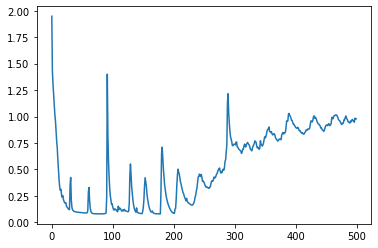

In [25]:
plt.plot(history.history['loss'])
plt.show()

In [52]:
tf.train.latest_checkpoint(checkpoint_dir)

'./RNN_checkpoints/ckpt_500'

# Востановим модель из кеша.

In [53]:
model = RNNgenerator(vocab_size, embedding_dim, rnn_units)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

## Генерация текста.

In [54]:
# Number of characters to generate
num_generate = 500

# Low temperature results in more predictable text.
# Higher temperature results in more surprising text.
# Experiment to find the best setting.
temperature = 1

In [55]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [56]:
text_ = generate_text(model, start_string=u"И вот идет уже ")
print(text_)

И вот идет уже тось          Кобренемитихо),
     некахорелы;
 вышилю.     ныенкродннедестодей на    ут,
   увуголера   за
     похобе егелыбалиназураго,
    Тусьяна  скодит нибназягнодумнеянила               буЯ   мо   X,
     жахотинь   итей;
    .      лою     жей      Ты,
  Я     нахомитла             восег  детумашет     пизьгеты      ся.    не               Песконы Кокана

        Iедетининажеротохов Ода,зит.          им
               зом?    вара,

      Одвыторю Я. т     . .
  Мевары.                 


### На 200-ой эпохе вродебы к-во было не плохим. Посмотрим как пройдет генерация текста. 

In [58]:
model = RNNgenerator(vocab_size, embedding_dim, rnn_units) 
model.load_weights('./RNN_checkpoints/ckpt_200')
model.build(tf.TensorShape([1, None]))

In [59]:
text_ = generate_text(model, start_string=u"И вот идет уже ")
print(text_)

И вот идет уже сяе  нан;
        ужей        бле,                   Году,      имней         жных                     Ко              .
   поленаблою           уй
       Вышижечеволяхому    ух стой.
        ги    бнама;
   ОтлилаблевТа,
 пой
   мгитыево     ди      поенниеслам  M}  ромой;   полноташидемером           Сочево     Ножедисевестря         му         Дойст     Вова  ноимихою   Мово,      Охией        млинегоченилы.
                  Вый     Гло Кадвыт         скла      бытесатей,
    Три            


# Дальше можно не смотреть.

Хотел проверить, как поведет себя модель с установленным параметром "return_state=True".(подсмотрел в методичке по [tensorflow]( https://www.tensorflow.org/text/tutorials/text_generation)), но видно придется отложить эти эксперименты на потом. Т.к. обучается модель ну очень долго!

# Попробуем обучить модель с сохранением состояния.

In [18]:
class RNNgenerator_1(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru2 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.gru3 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, x, states=None, return_state=False):

    x = self.embedding(x)

    if states is None:
      states = self.gru1.get_initial_state(x)

    x, states = self.gru1(x, initial_state=states)
    x, states = self.gru2(x, initial_state=states)
    x, states = self.gru3(x, initial_state=states)

    x = self.dense(x)

    if return_state:
      return x, states
    else:
      return x

In [19]:
# Directory where the checkpoints will be saved
checkpoint_dir = './RNN_1_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=1,
                                save_weights_only=True)

In [20]:
model_1 = RNNgenerator_1(
                 vocab_size= vocab_size,
                 embedding_dim=embedding_dim,
                 rnn_units=rnn_units,
                )

In [21]:
model_1.compile(optimizer='adam', loss=loss, metrics='accuracy')

In [22]:
EPOCHS = 200

In [23]:
history = model_1.fit(dataset,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback])

Epoch 1/200
19/88 [=====>........................] - ETA: 12:08 - loss: 2.8946 - accuracy: 0.5307

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.show()

## Генерация текста.

In [ ]:
def generate_text_1(model, start_string, states, temperature):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions, states = model(input_eval, states=states, return_state=True)
        predictions = tf.squeeze(predictions, 0)
        
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
num_generate = 500
temperature = 0.7
states = None
next_char = u"И вот идет уже "
text_generated=[]

In [ ]:
text = generate_text_1(model_1, next_char, states, temperature)
print(text)

# Model 2

In [ ]:
class RNNgenerator_2(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru2 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.gru3 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, x, states_1=None, states_2=None, states_3=None, return_state=False):

    x = self.embedding(x)

    if states is None:
      states_1 = self.gru1.get_initial_state(x)
      states_2 = self.gru1.get_initial_state(x)
      states_3 = self.gru1.get_initial_state(x)

    x, states_1 = self.gru1(x, initial_state=states_1)
    x, states_2 = self.gru2(x, initial_state=states_2)
    x, states_3 = self.gru3(x, initial_state=states_3)

    x = self.dense(x)

    if return_state:
      return x, states_1, states_2, states_3
    else:
      return x

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './RNN_2_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=1,
                                save_weights_only=True)

In [ ]:
model_2 = RNNgenerator_2(
                 vocab_size= vocab_size,
                 embedding_dim=embedding_dim,
                 rnn_units=rnn_units,
                )

In [ ]:
model_2.compile(optimizer='adam', loss=loss, metrics='accuracy')

In [ ]:
history = model_2.fit(dataset,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback])

In [ ]:
plt.plot(history.history['loss'])
plt.show()

In [ ]:
def generate_text_2(model, start_string, states_1, states_2, states_3, temperature):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions, states_1,states_2, states_3 = model(input_eval, states_1=states_1, states_2=states_2, states_3=states_3, return_state=True)
        predictions = tf.squeeze(predictions, 0)
        
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
num_generate = 500
temperature = 0.7
states = None
next_char = u"И вот идет уже "
text_generated=[]

In [ ]:
text = generate_text_2(model_2, next_char, states_1, states_2, states_3, temperature)
print(text)